
## Deep learning Classification of Trucks vs. Bikes using PyTorch and FastAI

This notebook demonstrates the use of the FastAI library to classify images of trucks and bikes. We will go through the following steps:

1. **Data Preparation**: Loading and preprocessing the dataset.
2. **Model Training**: Training a convolutional neural network (CNN) using transfer learning.
3. **Model Evaluation**: Evaluating the trained model using various metrics.
4. **Error Analysis**: Analyzing misclassifications to improve the model.
        

In [2]:
import requests
import os
import urllib.request
from google.colab import userdata
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from io import BytesIO

## First we need to download images of bikes and trucks from the internet

## For that we'll use Google Search API

In [3]:

### Here, let's download 100 pictures of trucks and bikes to train our model
### We'll be using Google Custom Search API

# Configuration
API_KEY = userdata.get('google_api_key')  # Kept safe in Google colab secret
CX = userdata.get('google_api_cx')   # Kept safe in Google colab secret
SEARCH_TERM_TRUCK = 'truck'
SEARCH_TERM_BIKE = 'bike'
NUM_IMAGES = 100  # Number of images for each category (trucks and bikes)
DOWNLOAD_TIMEOUT = 10  # Timeout for image download in seconds

# Function to fetch image URLs using Google Custom Search API
def fetch_image_urls(search_term, num_images, api_key, cx):
    search_url = f"https://www.googleapis.com/customsearch/v1?q={search_term}&cx={cx}&key={api_key}&searchType=image&num=10"
    image_urls = []
    for start in range(1, num_images, 10):
        response = requests.get(search_url + f"&start={start}")
        data = response.json()
        for item in data['items']:
            image_urls.append(item['link'])
        if len(image_urls) >= num_images:
            break
    return image_urls[:num_images]

# Function to download images
def download_images(image_urls, folder_name, timeout):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    for i, url in enumerate(image_urls):
        try:
            response = requests.get(url, timeout=timeout)
            # Verify the content type is an image
            if 'image' in response.headers.get('content-type', ''):
                img = Image.open(BytesIO(response.content))
                img.save(f"{folder_name}/{folder_name}_{i+1}.jpg")
                print(f"Downloaded {folder_name}_{i+1}.jpg")
            else:
                print(f"Skipped {url} - Not an image")
        except (requests.RequestException, UnidentifiedImageError, IOError) as e:
            print(f"Could not download {url} - {e}")

# Fetch image URLs
truck_image_urls = fetch_image_urls(SEARCH_TERM_TRUCK, NUM_IMAGES, API_KEY, CX)
bike_image_urls = fetch_image_urls(SEARCH_TERM_BIKE, NUM_IMAGES, API_KEY, CX)

# Download images
download_images(truck_image_urls, 'trucks', DOWNLOAD_TIMEOUT)
download_images(bike_image_urls, 'bikes', DOWNLOAD_TIMEOUT)

print("Download completed!")


Downloaded trucks_1.jpg
Could not download https://cdn11.bigcommerce.com/s-9tm5ngq0lw/images/stencil/original/products/315/1129/HESS2081-Plush-Bus-2024-Hero__86316.1710431258.png?c=2 - cannot write mode RGBA as JPEG
Downloaded trucks_3.jpg
Downloaded trucks_4.jpg
Downloaded trucks_5.jpg
Downloaded trucks_6.jpg
Downloaded trucks_7.jpg
Downloaded trucks_8.jpg
Downloaded trucks_9.jpg
Downloaded trucks_10.jpg
Could not download https://cdn11.bigcommerce.com/s-9tm5ngq0lw/images/stencil/640w/products/315/1121/HESS5209_2024Plush_OnSale_Animated_HeroAsset-1000x800-GIF-FINAL__42571.1708965781.gif - cannot write mode P as JPEG
Downloaded trucks_12.jpg
Downloaded trucks_13.jpg
Downloaded trucks_14.jpg
Downloaded trucks_15.jpg
Downloaded trucks_16.jpg
Could not download https://www.paccar.com/media/g0gpoll2/pb-589-overlay.png - cannot write mode RGBA as JPEG
Downloaded trucks_18.jpg
Skipped https://www.topgear.com/sites/default/files/2021/06/Hennessey%20Mammoth%201000%20TRX_001.jpg - Not an image


## Some images have not been downloaded because of errors

## Let's visualize a sample of these images

Number of truck images downloaded: 77
Number of bike images downloaded: 87
Sample truck images:


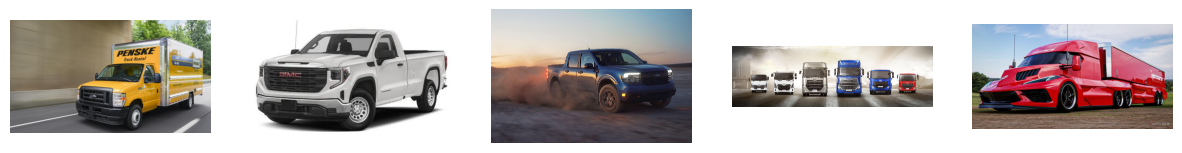

Sample bike images:


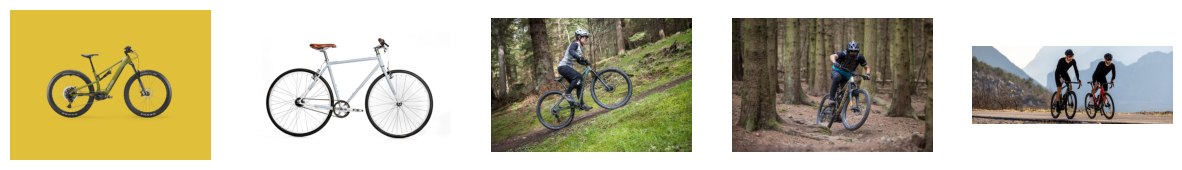

In [4]:


# Function to display a sample of images
def display_sample_images(folder_name, sample_size=5):
    image_files = [f for f in os.listdir(folder_name) if f.endswith('.jpg')]
    sample_files = image_files[:sample_size]

    fig, axs = plt.subplots(1, sample_size, figsize=(15, 3))
    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(folder_name, img_file)
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()


# Count the number of images in each folder
num_truck_images = len([f for f in os.listdir('trucks') if f.endswith('.jpg')])
num_bike_images = len([f for f in os.listdir('bikes') if f.endswith('.jpg')])

# Display number of images downloaded
print(f"Number of truck images downloaded: {num_truck_images}")
print(f"Number of bike images downloaded: {num_bike_images}")

# Display sample images
print("Sample truck images:")
display_sample_images('trucks')
print("Sample bike images:")
display_sample_images('bikes')

## Building the model using PyTorch

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Define transform for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
"""
Resize> Resizes the input image to a fixed size of 224x224 pixels as Neural Network needs image of fixed size
ToTensor > Purpose: Converts the PIL Image or numpy ndarray to a PyTorch tensor
Normalize > The values used here are the mean and standard deviation of the ImageNet dataset,
which is the dataset on which the ResNet models were originally trained.
Normalizing the input data ensures that the input distribution matches the distribution the pre-trained model expects.
This can significantly improve model performance and convergence speed.
"""

# Load the dataset
# To change depending on the structure of the folder
dataset = datasets.ImageFolder(root='/content/data/', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:

# Define the neural network model (using a pre-trained model)
model = models.resnet34(pretrained=True)
"""
ResNet-34 is a specific architecture of a deep convolutional neural
network known as ResNet (Residual Network). ResNet-34 consists of 34 layers
"""
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two classes: bikes and trucks
"""
We replace the original fully connected layer with a new one that has an output size of 2.
The nn.Linear layer is a fully connected layer, and here it takes num_ftrs
(the number of input features) and outputs 2 features,
corresponding to our two classes: bikes and trucks.
This customization is necessary because the original model was trained
to classify 1000 classes (ImageNet dataset),
and we need it to classify only 2 classes in our case.
"""

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
"""
This is a common loss function used for classification tasks.
Cross-entropy loss measures the performance of a classification model
whose output is a probability value between 0 and 1.
The loss increases as the predicted probability diverges from the actual label.
It is particularly suitable for multi-class classification problems, which fits
our binary classification (bikes vs. trucks) as it generalizes well even for two classes.
"""
optimizer = optim.Adam(model.parameters(), lr=0.001)
"""
optim.Adam: Adam (short for Adaptive Moment Estimation) is an optimization
algorithm that is widely used for training deep learning models.
It combines the advantages of two other extensions of stochastic gradient descent (SGD):
AdaGrad and RMSProp.

lr=0.001: This sets the learning rate for the optimizer.
The learning rate controls how much to change the model in response to the
estimated error each time the model weights are updated.
A smaller learning rate might lead to slower convergence but can result in a more precise model.
A larger learning rate can speed up training but might overshoot the optimal solution.
"""

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

# Save the model
torch.save(model.state_dict(), 'bike_truck_classifier.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 120MB/s]


Epoch 1/5, Loss: 1.1749874092638493
Validation Accuracy: 54.54545454545455%
Epoch 2/5, Loss: 1.807584747672081
Validation Accuracy: 63.63636363636363%
Epoch 3/5, Loss: 0.20596685037016868
Validation Accuracy: 63.63636363636363%
Epoch 4/5, Loss: 0.18335181176662446
Validation Accuracy: 72.72727272727273%
Epoch 5/5, Loss: 0.11266530007123947
Validation Accuracy: 72.72727272727273%


## Building the model using FastAI

FastAI abstracts many of the complexities and provides high-level functions that automatically apply best practices in training deep learning models like Data Augmentation, Early Stopping, Learning Rate scheduling, Differential learning rate

epoch,train_loss,valid_loss,accuracy,time
0,0.801485,0.315780,0.843750,00:58


epoch,train_loss,valid_loss,accuracy,time
0,0.060607,0.116433,0.968750,01:24
1,0.039295,0.115430,0.968750,01:24
2,0.047499,0.091659,0.968750,01:21
3,0.038979,0.088473,0.968750,01:24
4,0.031850,0.064316,0.968750,01:25


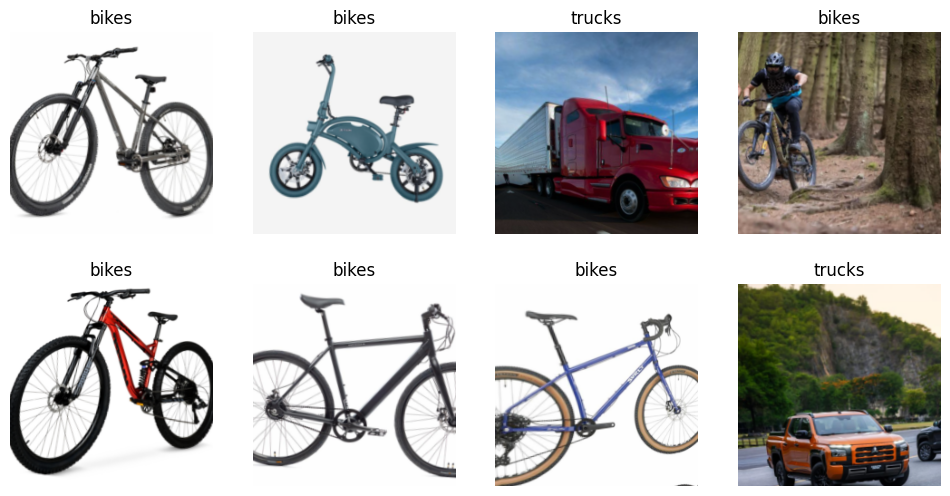

In [10]:
from fastai.vision.all import *

# Define the path to the dataset
path = Path('data')

# Ensure the dataset directory exists
if not path.is_dir():
    raise FileNotFoundError(f"Dataset directory not found: {path}")

# Create a DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define the types of inputs and targets
    get_items=get_image_files,           # How to get the list of files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split the data into training and validation sets
    get_y=parent_label,                  # How to get the labels (from the parent folder name)
    item_tfms=Resize(224),               # Resize images to a uniform size
    batch_tfms=aug_transforms(size=224)  # Data augmentation
)

# Create a DataLoaders object
dls = dblock.dataloaders(path, bs=32)

# Show a batch of images
dls.show_batch(max_n=8, nrows=2)

# Create a CNN learner using a pre-trained ResNet-34 model
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Fine-tune the model
learn.fine_tune(5)

# Save the model
learn.export('bike_truck_classifier.pkl')


## Let's plot a confusion matrix

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


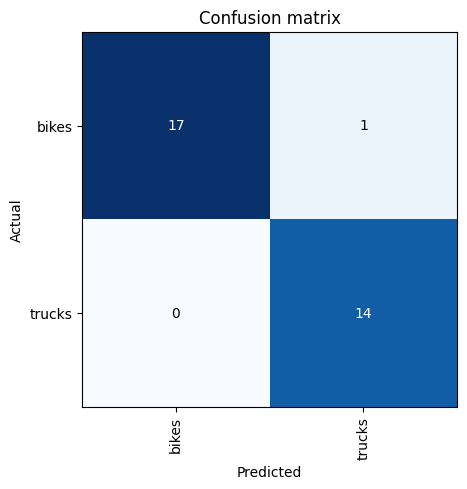

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

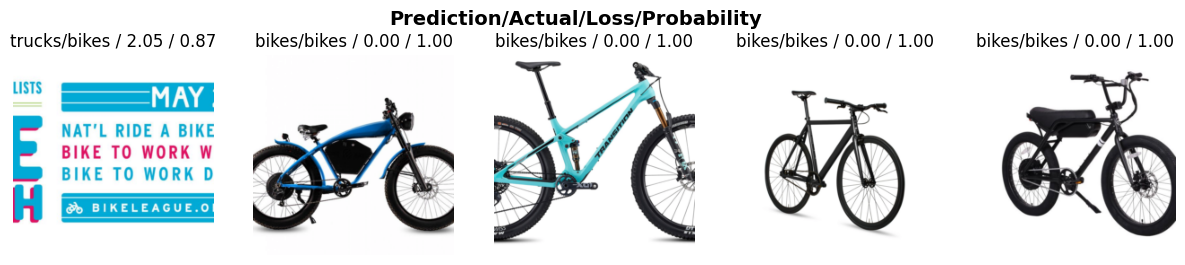

In [12]:
#We can see a bike has been predicted as a truck, let's investigate
interp.plot_top_losses(5, nrows=1)

## Indeed, our dataset had an image of something that did not really look like a bike, we should exclude this outlier!

## Let's test our model by uploading some pictures as a Testing dataset

In [ ]:
pip install ipywidgets

FileUpload(value={}, description='Upload')

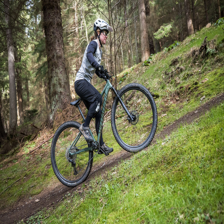

Prediction: bikes
Probability: 1.0000


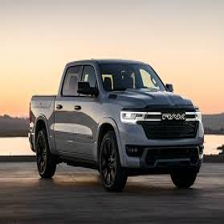

Prediction: trucks
Probability: 1.0000


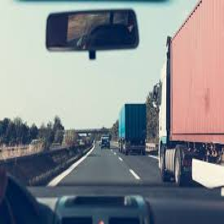

Prediction: trucks
Probability: 0.9995


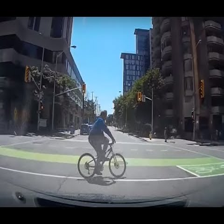

Prediction: bikes
Probability: 0.5470


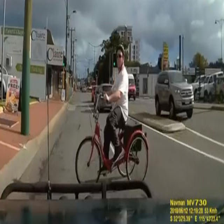

Prediction: trucks
Probability: 0.9820


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the trained model
learn = load_learner('bike_truck_classifier.pkl')

# Function to classify an uploaded image
def on_upload_change(change):
    #clear_output()
    for name, file_info in change['new'].items():
        img = PILImage.create(file_info['content'])
        img = img.resize((224, 224))  # Resize the image to 224x224 pixels
        pred, pred_idx, probs = learn.predict(img)
        display(img)
        print(f"Prediction: {pred}")
        print(f"Probability: {probs[pred_idx]:.4f}")

# Create an upload button
upload_button = widgets.FileUpload()
upload_button.observe(on_upload_change, names='value')

# Display the upload button
display(upload_button)


## We can see that the model performs well on clean and neat pictures but struggles more on dashcam-like pictures like the last 2. It is because the kind of pictures and not present in the training set and we would need to integrate more pictures like that if we want a production ready model

# Conclusion



In this notebook, we successfully demonstrated the classification of trucks vs. bikes using the FastAI library. We went through several steps including data preparation, model training, model evaluation, and error analysis. The model achieved good performance metrics, and we gained insights into areas where the model could potentially be improved by analyzing the misclassified images.

Key takeaways from this notebook include:

- The importance of data augmentation in improving model robustness.
- The effectiveness of transfer learning in training a high-performance model with limited data.
- The value of detailed evaluation metrics and confusion matrix in understanding model performance.

## Potential Next Steps


- Hyperparameter Tuning:

We could experiment with different hyperparameters such as learning rates, batch sizes, and optimizer types to optimize model performance.

- Advanced Data Augmentation:

We could apply more sophisticated data augmentation techniques such as Mixup or CutMix to further improve model generalization.

- Model Interpretability:

We could use techniques like Grad-CAM or SHAP to visualize what the model is focusing on when making predictions.

- Deploying the Model:

We could deploy the trained model as an API using frameworks like FastAPI or Flask to make it accessible for real-time predictions.

- Collecting More Data:

We could collect more labeled images to further train and improve the model, especially for classes where the model is currently underperforming.

- Transfer Learning with Different Architectures:

We could experiment with different pre-trained models and architectures to see if they offer better performance.